# INM702: Task 1

This task is about classifying images of written numbers from the MNIST dataset. We develop a neural network using basic libraries such as NumPy, without resorting to ready-made functions from TensorFlow, Keras or PyTorch.

The work presented here is part of the coursework of the INM702 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM702).

### Import Libraries and Load MNIST

We import the relevant libraries to create our neural network. We use TensorFlow only to import the MNIST dataset. One-hot encoding is performed on the data. We also normalise the data.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Ignore warnings (making the work easier to read)
import warnings
warnings.filterwarnings("ignore")

# Use TensorFlow to load MNIST (easy method)
import tensorflow.keras.datasets.mnist as mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [2]:
# Length * Width
image_pixels = X_train.shape[1] * X_train.shape[1]

# Convert training and test sets to 2-D arrays, and normalise
X_train = X_train.reshape((X_train.shape[0], image_pixels)).T / 255.0
X_test = X_test.reshape((X_test.shape[0], image_pixels)).T / 255.0

# One-hot encoder function
def one_hot_encoder(labels):
    num_classes = np.max(labels) + 1
    one_hot_labels = np.eye(num_classes)[labels]
    return one_hot_labels

y_train_one_hot = one_hot_encoder(y_train).T
y_test_one_hot = one_hot_encoder(y_test).T

X_train.shape, X_test.shape, y_train_one_hot.shape, y_test_one_hot.shape

((784, 60000), (784, 10000), (10, 60000), (10, 10000))

### Sigmoid, ReLU and Softmax Layers

We create functions for the Sigmoid, ReLU and Softmax layers. Each can be used for forward pass and backward pass.

In [3]:
# Sigmoid with derivative
def sigmoid(x):
    s = 1.0 / (1.0 + np.exp(-x))
    ds = s * (1.0 - s)
    return s, ds

# ReLU with derivative   ()
def relu(x):
    return x * (x >= 0), (x > 0).astype(float)

# Softmax with derivative
def softmax(vec):
    s = np.exp(vec) / np.exp(vec).sum()
    return s, s * (np.eye(s.size) - s.reshape(-1, 1))

# Softmax with correction for underflow/overflow (and derivative)
def softmax_corrected(vec):
    vec = vec - np.max(vec)
    s = np.exp(vec) / np.exp(vec).sum()
    return s, s * (np.eye(s.size) - s.reshape(-1, 1))

Sigmoid/Derivative



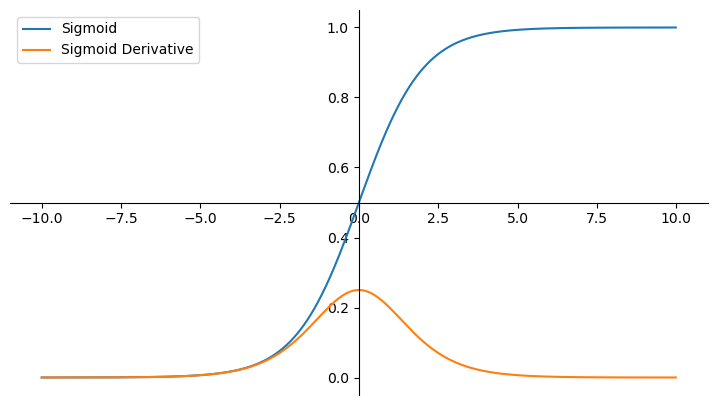

ReLU/Derivative


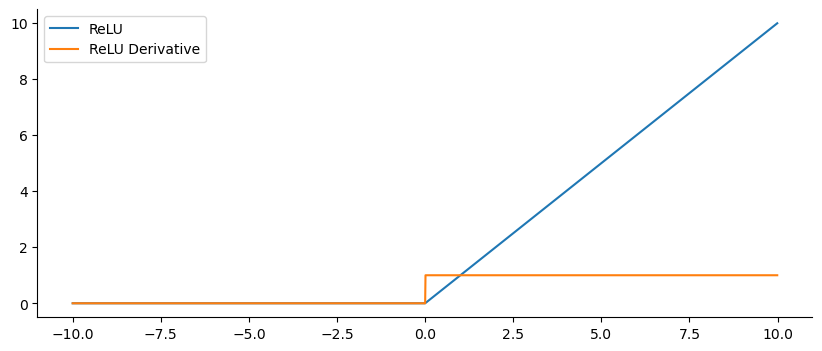

In [4]:
# Set range of input values for Sigmoid and ReLU
x = np.arange(-10, 10, 0.01)

# Generate Sigmoid/Derivative Plot
print("Sigmoid/Derivative\n")

fig1, ax1 = plt.subplots(figsize=(9, 5))

ax1.spines["left"].set_position("center")
ax1.spines["bottom"].set_position("center")
ax1.spines["top"].set_color("none")
ax1.spines["right"].set_color("none")

ax1.plot(x, sigmoid(x)[0], label = "Sigmoid")
ax1.plot(x, sigmoid(x)[1], label = "Sigmoid Derivative")
ax1.legend(loc = "upper left")
plt.show()

# Generate ReLU/Derivative Plot
print("ReLU/Derivative")

fig2, ax2 = plt.subplots(figsize = (10, 4))

ax2.spines["top"].set_color("none")
ax2.spines["right"].set_color("none")

ax2.plot(x, relu(x)[0], label = "ReLU")
ax2.plot(x, relu(x)[1], label = "ReLU Derivative")
ax2.legend(loc = "upper left")
plt.show()

In [5]:
# Presenting the difference between the two softmax functions

print(softmax([1,2000,-535])[0])
print(softmax_corrected([1,2000,-535])[0])

[ 0. nan  0.]
[0. 1. 0.]


### Set Random Seeds

In [6]:
# Random Seed and Seed Choice

randomer = 50
random.seed(randomer)
np.random.seed(randomer)

### Neural Network Class

We create a neural network class that takes 4 parameters, which are detailed below. The class can handle multiple layers and dropout regularisation. Stochastic gradient descent and mini-batch gradient descent are the two optimisers.

In [23]:
# Neural Network Class

class NeuralNetwork:
    """
    Neural Network Class

    Parameters:
    - layer_sizes: A list containing first the input size, and lastly the output size. Hidden layers can optionally be added
      in between. For example [10, 128, 64, 2] for input of size 10, two hidden layers of size 128 and 64 respectively,
      and output of size 2.
    - activation_function: Activation function used in every layer.
    - dropout_rate: The probability of keeping a neuron inactive during dropout. A float between 0 and 1, where 0 means no dropout.
    - random_state: Seed used to generate the random weights. If no seed is specified, the seed set as 'randomer' will be used.
    """
    def __init__(self, layer_sizes,l1,l2, activation_function = relu, dropout_rate = 0, random_state = randomer):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.activation_function = activation_function
        self.random_state = random_state
        self.parameters = self.initialise_parameters()
        self.dropout_rate = dropout_rate
        self.dropout_masks = None
        self.l1 = l1  # L1 regularization hyperparameter
        self.l2 = l2 
    
    # Forward propagation
    def forward_propagation(self, X, is_training=True):
        # Store input values at layer and create dictionary for dropout (if used)
        cache = {"A0": X}
        self.dropout_masks = {}

        # Start from the beginning of the neural network
        for l in range(1, self.num_layers):
            # Get weights and bias at layer, and retrieve activation from the previous layer
            Wl, bl = self.parameters[f"W{l}"], self.parameters[f"b{l}"]
            Al_prev = cache[f"A{l - 1}"]

            # Calculate weighted sum with bias at layer
            Zl = np.dot(Wl, Al_prev) + bl

            # Apply dropout during training, excluding the output layer
            if is_training and self.dropout_rate > 0 and l < self.num_layers - 1:
                dropout_mask = (np.random.rand(*Zl.shape) < self.dropout_rate) / (1 - self.dropout_rate)
                self.dropout_masks[f"mask{l}"] = dropout_mask
                Zl *= dropout_mask

            # Apply transformation function to weighted sum
            Al = self.activation_function(Zl)[0]

            # Store weighted sum and activation
            cache[f"Z{l}"] = Zl
            cache[f"A{l}"] = Al

        return Al, cache
    


    # Backpropagation
    def backpropagation(self, A, Y, cache):
        m = Y.shape[1]
        # Create dictionary to store the gradients
        gradients = {}
        
        # Compute errors at layer
        dZ = A - Y
        # Start from end of neural network
        for l in reversed(range(1, self.num_layers)):
            # Get weights at layer, and retrieve activation from previous layer
            Al_prev = cache[f"A{l - 1}"]
            Wl = self.parameters[f"W{l}"]

            # Apply dropout during backpropagation (This ensures that the dropped neurons don't contribute to weight updates during training.)
            if f"mask{l}" in self.dropout_masks:
                dZ *= self.dropout_masks[f"mask{l}"]
            
            # Add weight and bias gradients to dictionary
            gradients[f"dW{l}"] = np.dot(dZ, Al_prev.T) / m
            gradients[f"db{l}"] = np.sum(dZ, axis = 1, keepdims = True) / m
            
            # Compute derivative using activation function
            dZ = np.dot(Wl.T, dZ) * self.activation_function(Al_prev)[1]

        return gradients
        
    # Initialise weights
    def initialise_parameters(self):
        # Use random seed defined in the class parameters
        np.random.seed(self.random_state)
        # Create dictionary to store the weights
        parameters = {}
        # Go over each layer and create random weights
        for l in range(1, self.num_layers):
            # Normal distribution with mean 0 and standard deviation 0.01
            parameters[f"W{l}"] = np.random.randn(self.layer_sizes[l], self.layer_sizes[l - 1]) * 0.01
            parameters[f"b{l}"] = np.zeros((self.layer_sizes[l], 1))
        return parameters

    # Categorical cross-entropy loss function
    def compute_categorical_cross_entropy_loss(self, A, Y):
        m = Y.shape[1]
    
        # Clip probabilities to avoid log(0) issues
        epsilon = 1e-15
        A = np.clip(A, epsilon, 1 - epsilon)
    
        # Compute categorical cross-entropy loss
        loss = -np.sum(Y * np.log(A)) / m
    
        return loss
    
    # Accuracy function
    def compute_accuracy(self, A, Y):
        # Define the predicted labels
        predicted_labels = np.argmax(A, axis = 0)
        # Define the true labels
        true_labels = np.argmax(Y, axis = 0)
        return np.sum(predicted_labels == true_labels) / len(true_labels)
    

    def compute_cost_with_regularization(self, A, Y):
        m = Y.shape[1]
        # Cross-entropy loss without regularization
        cross_entropy_loss = self.compute_categorical_cross_entropy_loss(A, Y)
        # Compute L1 and L2 regularization terms for weights
        l1_regularization = 0
        l2_regularization = 0
        for l in range(1, self.num_layers):
            l1_regularization += np.sum(np.abs(self.parameters[f"W{l}"]))
            l2_regularization += np.sum(np.square(self.parameters[f"W{l}"]))
        # Calculate the total cost with regularization
        cost = cross_entropy_loss + (self.l1 / (2 * m)) * l1_regularization + (self.l2 / (2 * m)) * l2_regularization
        return cost

    
    # Function to train data, with epochs, learning rate, optimiser, and batch size as parameters
    def train(self, X, Y, num_epochs = 50, learning_rate = 0.1, optimizer = "mini_batch", batch_size = 32):
        # Save accuracy and losses to lists
        accuracies = []
        losses = []

        m = X.shape[1]

        # Loop over every epoch
        for epoch in range(num_epochs):
            # Shuffle the data for each epoch
            if batch_size and batch_size < m:
                indices = np.random.permutation(m)
                X_shuffled = X[:, indices]
                Y_shuffled = Y[:, indices]
            else:
                X_shuffled = X
                Y_shuffled = Y

            # Loop over mini-batches
            for i in range(0, m, batch_size or m):
                X_mini_batch = X_shuffled[:, i:i + batch_size] if batch_size else X_shuffled
                Y_mini_batch = Y_shuffled[:, i:i + batch_size] if batch_size else Y_shuffled

                # Forward propagation
                A, cache = self.forward_propagation(X_mini_batch)

                # Compute loss
                # loss = self.compute_categorical_cross_entropy_loss(A, Y_mini_batch)
                loss = self.compute_cost_with_regularization(A, Y_mini_batch)

                # Compute accuracy
                accuracy = self.compute_accuracy(A, Y_mini_batch)

                # Backpropagation
                gradients = self.backpropagation(A, Y_mini_batch, cache)

                # Update parameters using the specified optimiser
                if optimizer == "sgd":
                    self.update_parameters_sgd(gradients, learning_rate)
                    
                elif optimizer == "mini_batch":
                    self.update_parameters_mini_batch(gradients, learning_rate, len(X_mini_batch[1]))

            # Output epoch number and loss value
            print(f"Epoch {epoch}, Accuracy: {round(accuracy * 100, 4)}%, Loss: {round(loss, 4)}")

            # Append accuracy and loss values to lists
            accuracies.append(accuracy)
            losses.append(loss)

        return accuracies, losses

    # Update weights using Stochastic Gradient Descent
    def update_parameters_sgd(self, gradients, learning_rate):
        # Gradient descent
        for l in range(1, self.num_layers):
            self.parameters[f"W{l}"] -= learning_rate * gradients[f"dW{l}"]
            self.parameters[f"b{l}"] -= learning_rate * gradients[f"db{l}"]

    # Update weights using Mini-Batch Gradient Descent
    def update_parameters_mini_batch(self, gradients, learning_rate, mini_batch_size):
        # Gradient descent with mini-batch
        for l in range(1, self.num_layers):
            self.parameters[f"W{l}"] -= learning_rate * gradients[f"dW{l}"] / mini_batch_size
            self.parameters[f"b{l}"] -= learning_rate * gradients[f"db{l}"] / mini_batch_size
    
    # Function for making predictions
    def predict(self, X):
        # Predict using forward propagation
        predictions, _ = self.forward_propagation(X, is_training = False)
        return predictions
    
    # Function to generate a confusion matrix
    def confusion_matrix(self, true_labels, predicted_labels):
        # Identify number of classes
        num_classes = len(np.unique(true_labels))
        # Create matrix of zeroes of size (num_classes * num_classes)
        cm = np.zeros((num_classes, num_classes), dtype = int)
        
        # Fill in the confusion matrix appropriately
        for true, predicted in zip(true_labels, predicted_labels):
            cm[true, predicted] += 1

        return cm
    
    # Function to plot confusion matrix from 'confusion_matrix'
    def plot_confusion_matrix(self, cm, classes):
        plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")

        # Add text annotations for each cell in the confusion matrix
        for i in range(len(classes)):
            for j in range(len(classes)):
                plt.text(j, i, str(cm[i, j]), ha = "center", va = "center", color = "white" if cm[i, j] > cm.max() / 2 else "black")

        plt.show()
    
    # Generate and plot confusion matrix from 'confusion_matrix' and 'plot_confusion_matrix', using the model
    def evaluate_confusion_matrix(self, X, Y, classes):
        # Make predictions of test set (or otherwise) using the model
        predictions = self.predict(X)
        # Define the predicted labels
        predicted_labels = np.argmax(predictions, axis = 0)
        # Define the true labels
        true_labels = np.argmax(Y, axis = 0)
        
        # Create and plot confusion matrix
        cm = self.confusion_matrix(true_labels, predicted_labels)
        self.plot_confusion_matrix(cm, classes = classes)

        return cm

### Hyperparameters

Set hyperparameters to be used in initial model.

In [24]:
dropout_rate = 0
activation_function = sigmoid
num_epochs = 150
learning_rate = 0.1
optimizer = "mini_batch"
batch_size = 32

# Define layer sizes (input, hidden, output)

input_size = X_train.shape[0]
output_size = y_train_one_hot.shape[0]
layer_sizes = [input_size, 64, output_size]

### Train Base Neural Network Model

We train our neural network on our training set. The sigmoid activation function is used, as well as mini-batch gradient descent. The neural network contains one hidden layer of 64 nodes.

In [32]:
# Define model and train neural network on training set

model = NeuralNetwork(l1 = 0.05,l2 = 0.05,layer_sizes = layer_sizes, activation_function = activation_function, dropout_rate = dropout_rate, random_state = randomer)
history = model.train(X_train, y_train_one_hot, num_epochs = num_epochs, learning_rate = learning_rate, optimizer = optimizer, batch_size = batch_size)

Epoch 0, Accuracy: 3.125%, Loss: 2.6448
Epoch 1, Accuracy: 21.875%, Loss: 2.6372
Epoch 2, Accuracy: 34.375%, Loss: 2.5866
Epoch 3, Accuracy: 53.125%, Loss: 2.3912
Epoch 4, Accuracy: 46.875%, Loss: 2.3288
Epoch 5, Accuracy: 65.625%, Loss: 2.159
Epoch 6, Accuracy: 71.875%, Loss: 1.9971
Epoch 7, Accuracy: 68.75%, Loss: 1.9717
Epoch 8, Accuracy: 78.125%, Loss: 1.8305
Epoch 9, Accuracy: 71.875%, Loss: 1.9203
Epoch 10, Accuracy: 78.125%, Loss: 1.9348
Epoch 11, Accuracy: 75.0%, Loss: 2.0779
Epoch 12, Accuracy: 81.25%, Loss: 2.0096
Epoch 13, Accuracy: 84.375%, Loss: 2.1371
Epoch 14, Accuracy: 78.125%, Loss: 2.2629
Epoch 15, Accuracy: 75.0%, Loss: 2.0321
Epoch 16, Accuracy: 87.5%, Loss: 1.9309
Epoch 17, Accuracy: 90.625%, Loss: 2.0242
Epoch 18, Accuracy: 90.625%, Loss: 2.0713
Epoch 19, Accuracy: 71.875%, Loss: 2.6143
Epoch 20, Accuracy: 81.25%, Loss: 2.5526
Epoch 21, Accuracy: 75.0%, Loss: 2.5369
Epoch 22, Accuracy: 96.875%, Loss: 2.0471
Epoch 23, Accuracy: 93.75%, Loss: 2.174
Epoch 24, Accurac

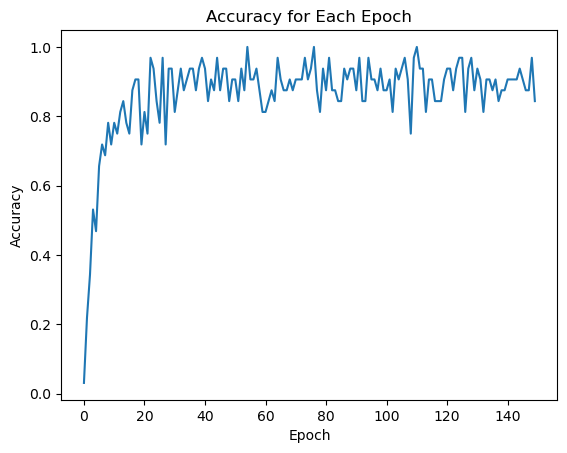

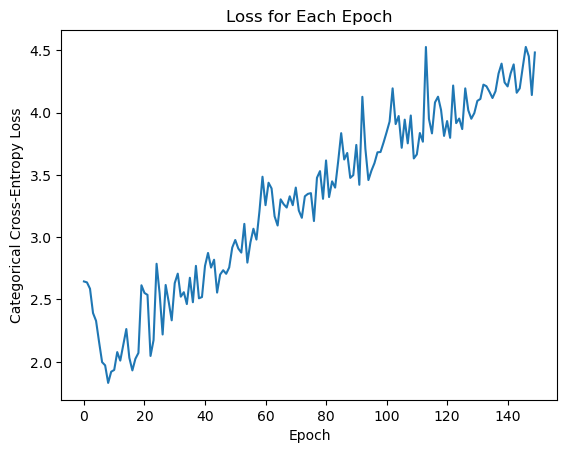

In [33]:
# Display accuracy per epoch

plt.plot(history[0])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy for Each Epoch")
plt.show()

# Display loss per epoch

plt.plot(history[1])
plt.xlabel("Epoch")
plt.ylabel("Categorical Cross-Entropy Loss")
plt.title("Loss for Each Epoch")
plt.show()

### Test Base Neural Network Model (Metrics)

We test our trained model on our test set. We compute the accuracy and loss, and generate a confusion matrix.

In [40]:
# Test the neural network
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = model.compute_accuracy(predictions, y_test_one_hot)
# loss = model.compute_categorical_cross_entropy_loss(predictions, y_test_one_hot)
loss = model.compute_cost_with_regularization(predictions, y_test_one_hot)

print(f"Accuracy: {round(accuracy, 4) * 100}%")
print(f"Loss: {round(loss, 4)}")

Accuracy: 91.86999999999999%
Loss: 0.3552


In [41]:
# Test the neural network
predictions = model.predict(X_test)

# Calculate accuracy
accuracy = model.compute_accuracy(predictions, y_test_one_hot)
loss = model.compute_categorical_cross_entropy_loss(predictions, y_test_one_hot)

print(f"Accuracy: {round(accuracy, 4) * 100}%")
print(f"Loss: {round(loss, 4)}")

Accuracy: 91.86999999999999%
Loss: 0.3425


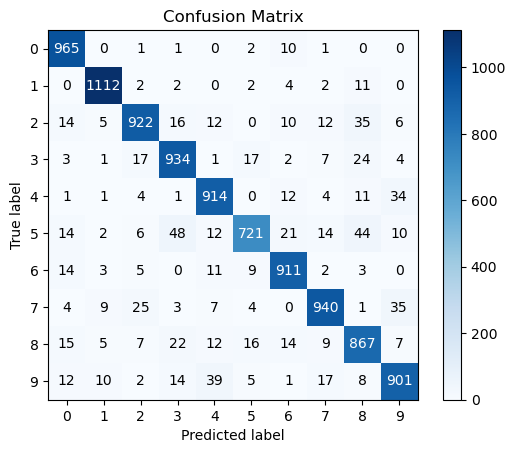

array([[ 965,    0,    1,    1,    0,    2,   10,    1,    0,    0],
       [   0, 1112,    2,    2,    0,    2,    4,    2,   11,    0],
       [  14,    5,  922,   16,   12,    0,   10,   12,   35,    6],
       [   3,    1,   17,  934,    1,   17,    2,    7,   24,    4],
       [   1,    1,    4,    1,  914,    0,   12,    4,   11,   34],
       [  14,    2,    6,   48,   12,  721,   21,   14,   44,   10],
       [  14,    3,    5,    0,   11,    9,  911,    2,    3,    0],
       [   4,    9,   25,    3,    7,    4,    0,  940,    1,   35],
       [  15,    5,    7,   22,   12,   16,   14,    9,  867,    7],
       [  12,   10,    2,   14,   39,    5,    1,   17,    8,  901]])

In [42]:
# Output confusion matrix

# 10 classes (as there are 10 digits)
class_names = [str(i) for i in range(10)]

# Call model and output confusion matrix
model.evaluate_confusion_matrix(X_test, y_test_one_hot, classes = class_names)

### Evaluate Different Architectures/Parameters

We try changing the activation function to ReLU, use mini-batch gradient descent and stochastic gradient descent, and adjust the learning rate. We try changing the neural network architecture to include two hidden layers, and we introduce dropout regularisation.

#### Alternate Model 1

Proportion of nodes dropped for dropout regularisation is 30%. 
We use the ReLU activation function 
 mini-batch gradient descent,  learning rate of 1 and batch size of 32. We use two hidden layers here each containing 64 nodes.

In [13]:
dropout_rate = 0.3
activation_function = relu
num_epochs = 150
learning_rate = 1
optimizer = "mini_batch"
batch_size = 32

# Define layer sizes (input, hidden, output)

input_size = X_train.shape[0]
output_size = y_train_one_hot.shape[0]
layer_sizes = [input_size, 64, 64, output_size]

In [14]:
# Define model and train neural network on training set

model_2 = NeuralNetwork(layer_sizes = layer_sizes, activation_function = activation_function, dropout_rate = dropout_rate, random_state = randomer)
history_2 = model_2.train(X_train, y_train_one_hot, num_epochs = num_epochs, learning_rate = learning_rate, optimizer = optimizer, batch_size = batch_size)

Epoch 0, Accuracy: 6.25%, Loss: 2.298
Epoch 1, Accuracy: 12.5%, Loss: 2.2992
Epoch 2, Accuracy: 15.625%, Loss: 2.3047
Epoch 3, Accuracy: 15.625%, Loss: 2.0364
Epoch 4, Accuracy: 46.875%, Loss: 1.6797
Epoch 5, Accuracy: 53.125%, Loss: 1.5058
Epoch 6, Accuracy: 43.75%, Loss: 3.4366
Epoch 7, Accuracy: 50.0%, Loss: 2.1534
Epoch 8, Accuracy: 62.5%, Loss: 3.0133
Epoch 9, Accuracy: 53.125%, Loss: 2.1971
Epoch 10, Accuracy: 68.75%, Loss: 0.8698
Epoch 11, Accuracy: 78.125%, Loss: 0.8407
Epoch 12, Accuracy: 68.75%, Loss: 0.8606
Epoch 13, Accuracy: 90.625%, Loss: 0.6061
Epoch 14, Accuracy: 68.75%, Loss: 0.9809
Epoch 15, Accuracy: 71.875%, Loss: 2.8541
Epoch 16, Accuracy: 71.875%, Loss: 1.7218
Epoch 17, Accuracy: 78.125%, Loss: 2.8595
Epoch 18, Accuracy: 71.875%, Loss: 1.662
Epoch 19, Accuracy: 87.5%, Loss: 3.7356
Epoch 20, Accuracy: 65.625%, Loss: 0.7259
Epoch 21, Accuracy: 93.75%, Loss: 0.5431
Epoch 22, Accuracy: 84.375%, Loss: 0.59
Epoch 23, Accuracy: 84.375%, Loss: 1.6618
Epoch 24, Accuracy: 8

In [15]:
# Test the neural network
predictions = model_2.predict(X_test)

# Calculate accuracy
accuracy = model_2.compute_accuracy(predictions, y_test_one_hot)
loss = model_2.compute_categorical_cross_entropy_loss(predictions, y_test_one_hot)

print(f"Accuracy: {round(accuracy, 4) * 100}%")
print(f"Loss: {round(loss, 4)}")

Accuracy: 93.75%
Loss: 1.9073


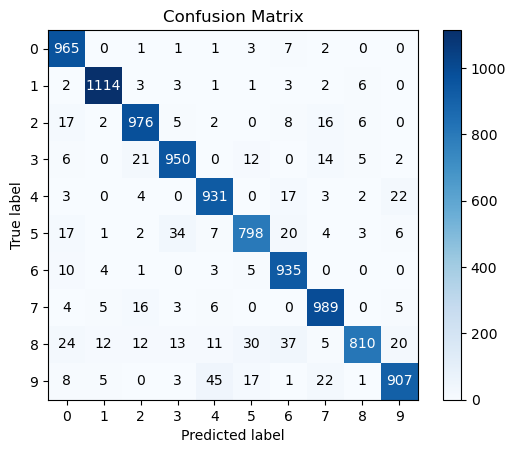

array([[ 965,    0,    1,    1,    1,    3,    7,    2,    0,    0],
       [   2, 1114,    3,    3,    1,    1,    3,    2,    6,    0],
       [  17,    2,  976,    5,    2,    0,    8,   16,    6,    0],
       [   6,    0,   21,  950,    0,   12,    0,   14,    5,    2],
       [   3,    0,    4,    0,  931,    0,   17,    3,    2,   22],
       [  17,    1,    2,   34,    7,  798,   20,    4,    3,    6],
       [  10,    4,    1,    0,    3,    5,  935,    0,    0,    0],
       [   4,    5,   16,    3,    6,    0,    0,  989,    0,    5],
       [  24,   12,   12,   13,   11,   30,   37,    5,  810,   20],
       [   8,    5,    0,    3,   45,   17,    1,   22,    1,  907]])

In [16]:
# Output confusion matrix

# 10 classes (as there are 10 digits)
class_names = [str(i) for i in range(10)]

# Call model and output confusion matrix
model_2.evaluate_confusion_matrix(X_test, y_test_one_hot, classes = class_names)

#### Alternate Model 2

Proportion of nodes dropped for dropout regularisation is 30%. We use the ReLU activation function, stochastic gradient descent, learning rate of 1 and no batch size. One hidden layer is used here.

In [17]:
dropout_rate = 0.3
activation_function = relu
num_epochs = 150
learning_rate = 1
optimizer = "sgd"
batch_size = None

# Define layer sizes (input, hidden, output)

input_size = X_train.shape[0]
output_size = y_train_one_hot.shape[0]
layer_sizes = [input_size, 64, output_size]

In [18]:
# Define model and train neural network on training set

model_3 = NeuralNetwork(layer_sizes = layer_sizes, activation_function = activation_function, dropout_rate = dropout_rate, random_state = randomer)
history_3 = model_3.train(X_train, y_train_one_hot, num_epochs = num_epochs, learning_rate = learning_rate, optimizer = optimizer, batch_size = batch_size)

Epoch 0, Accuracy: 11.3717%, Loss: 16.4024
Epoch 1, Accuracy: 13.9333%, Loss: 2.2559
Epoch 2, Accuracy: 18.6117%, Loss: 2.2774
Epoch 3, Accuracy: 23.2783%, Loss: 2.2596
Epoch 4, Accuracy: 27.8967%, Loss: 2.2403
Epoch 5, Accuracy: 31.8633%, Loss: 2.2176
Epoch 6, Accuracy: 34.7217%, Loss: 2.1892
Epoch 7, Accuracy: 36.3767%, Loss: 2.1558
Epoch 8, Accuracy: 37.9183%, Loss: 2.1142
Epoch 9, Accuracy: 38.9817%, Loss: 2.0691
Epoch 10, Accuracy: 40.1367%, Loss: 2.0163
Epoch 11, Accuracy: 41.5283%, Loss: 1.9593
Epoch 12, Accuracy: 42.8117%, Loss: 1.9023
Epoch 13, Accuracy: 44.1867%, Loss: 1.8461
Epoch 14, Accuracy: 45.3283%, Loss: 1.7947
Epoch 15, Accuracy: 46.68%, Loss: 1.7527
Epoch 16, Accuracy: 48.1733%, Loss: 1.7118
Epoch 17, Accuracy: 49.4383%, Loss: 1.6712
Epoch 18, Accuracy: 50.2983%, Loss: 1.6547
Epoch 19, Accuracy: 51.435%, Loss: 1.6311
Epoch 20, Accuracy: 52.8117%, Loss: 1.6026
Epoch 21, Accuracy: 53.6033%, Loss: 1.6132
Epoch 22, Accuracy: 54.8233%, Loss: 1.5873
Epoch 23, Accuracy: 55.

In [19]:
# Test the neural network
predictions = model_3.predict(X_test)

# Calculate accuracy
accuracy = model_3.compute_accuracy(predictions, y_test_one_hot)
loss = model_3.compute_categorical_cross_entropy_loss(predictions, y_test_one_hot)

print(f"Accuracy: {round(accuracy, 4) * 100}%")
print(f"Loss: {round(loss, 4)}")

Accuracy: 90.41%
Loss: 1.1128


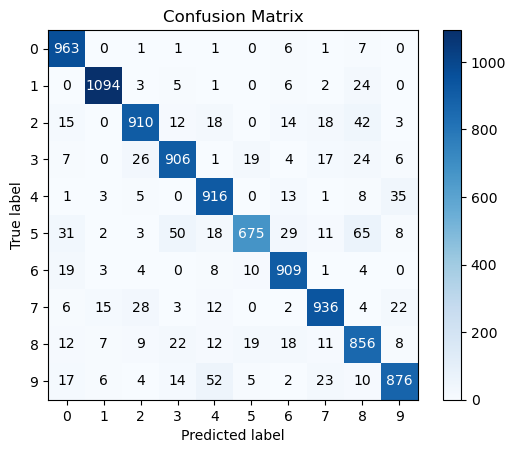

array([[ 963,    0,    1,    1,    1,    0,    6,    1,    7,    0],
       [   0, 1094,    3,    5,    1,    0,    6,    2,   24,    0],
       [  15,    0,  910,   12,   18,    0,   14,   18,   42,    3],
       [   7,    0,   26,  906,    1,   19,    4,   17,   24,    6],
       [   1,    3,    5,    0,  916,    0,   13,    1,    8,   35],
       [  31,    2,    3,   50,   18,  675,   29,   11,   65,    8],
       [  19,    3,    4,    0,    8,   10,  909,    1,    4,    0],
       [   6,   15,   28,    3,   12,    0,    2,  936,    4,   22],
       [  12,    7,    9,   22,   12,   19,   18,   11,  856,    8],
       [  17,    6,    4,   14,   52,    5,    2,   23,   10,  876]])

In [20]:
# Output confusion matrix

# 10 classes (as there are 10 digits)
class_names = [str(i) for i in range(10)]

# Call model and output confusion matrix
model_3.evaluate_confusion_matrix(X_test, y_test_one_hot, classes = class_names)